<a href="https://colab.research.google.com/github/navthik/NeuroLens/blob/master/Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle

In [ ]:
train_dir = '/content/drive/MyDrive/MRI Images/Training/'
test_dir = '/content/drive/MyDrive/MRI Images/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)


test_paths = []
test_labels = []

for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)




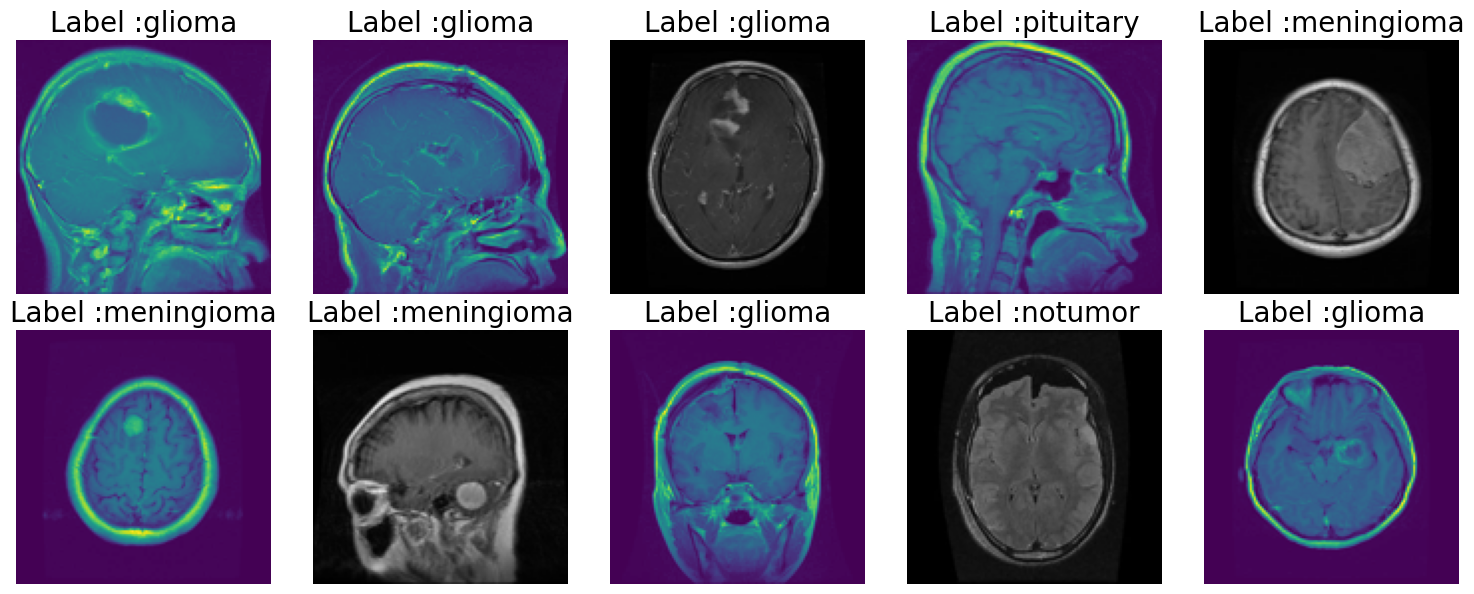

In [ ]:
import random
import matplotlib.pyplot as plt
random_indices = random.sample(range(len(train_paths)),10)

fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((128, 128))

  axes[i].imshow(img)
  axes[i].axis("off")
  axes[i].set_title(f"Label :{train_labels[idx]}", fontsize = 20)

plt.tight_layout()
plt.show()

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

def open_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = img_to_array(img)
        img = augment_image(img)
        images.append(img)
    return np.array(images)

def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return encoded

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, np.array(batch_labels)


In [ ]:
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
  layer.trainable = False

base_model.layers[-2].trainabe = True
base_model.layers[-3].trainabe = True
base_model.layers[-4].trainabe = True

model = Sequential()
model.add(Input(shape = (IMAGE_SIZE,IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)),activation = 'softmax'))


model.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 5

history = model.fit(datagen(train_paths, train_labels, batch_size = batch_size, epochs = epochs),epochs = epochs, steps_per_epoch = steps)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1256s 4s/step - loss: 0.8744 - sparse_categorical_accuracy: 0.6383
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1174s 4s/step - loss: 0.4271 - sparse_categorical_accuracy: 0.8329
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1202s 4s/step - loss: 0.3601 - sparse_categorical_accuracy: 0.8625
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1198s 4s/step - loss: 0.3072 - sparse_categorical_accuracy: 0.8828
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1181s 4s/step - loss: 0.2885 - sparse_categorical_accuracy: 0.8923


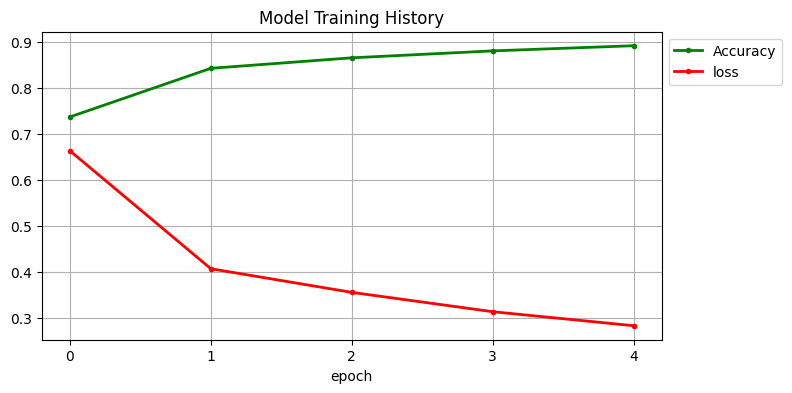

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth = 2)
plt.plot(history.history['loss'], '.r-', linewidth = 2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy','loss'], loc = 'upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np


test_images = open_images(test_paths)


label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)


test_predictions = model.predict(test_images)
predicted_classes = np.argmax(test_predictions, axis=1)


print("=== Classification Report ===")
print(classification_report(test_labels_encoded, predicted_classes, target_names=label_encoder.classes_))


41/41 ━━━━━━━━━━━━━━━━━━━━ 264s 6s/step
=== Classification Report ===
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.75      0.83      0.79       306
     notumor       0.03      0.02      0.02       405
   pituitary       0.93      0.95      0.94       300

    accuracy                           0.42      1311
   macro avg       0.43      0.45      0.44      1311
weighted avg       0.40      0.42      0.41      1311



Confusion Matrix:
[[  0  57 239   4]
 [ 14 255  20  17]
 [381  17   7   0]
 [  1  12   3 284]]


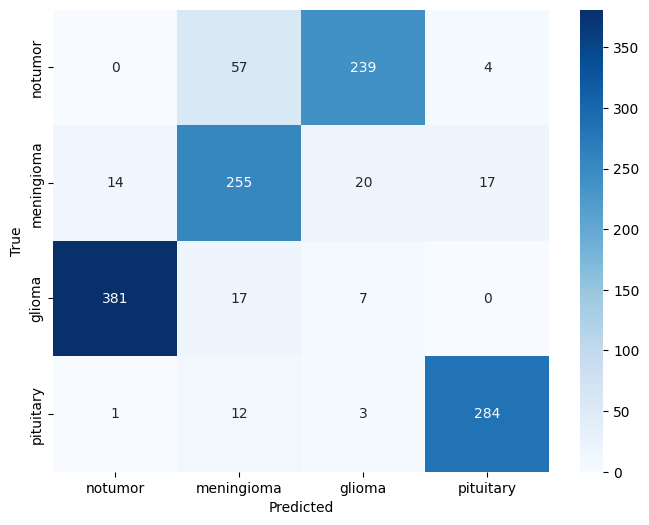

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=os.listdir(train_dir),
            yticklabels=os.listdir(train_dir))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



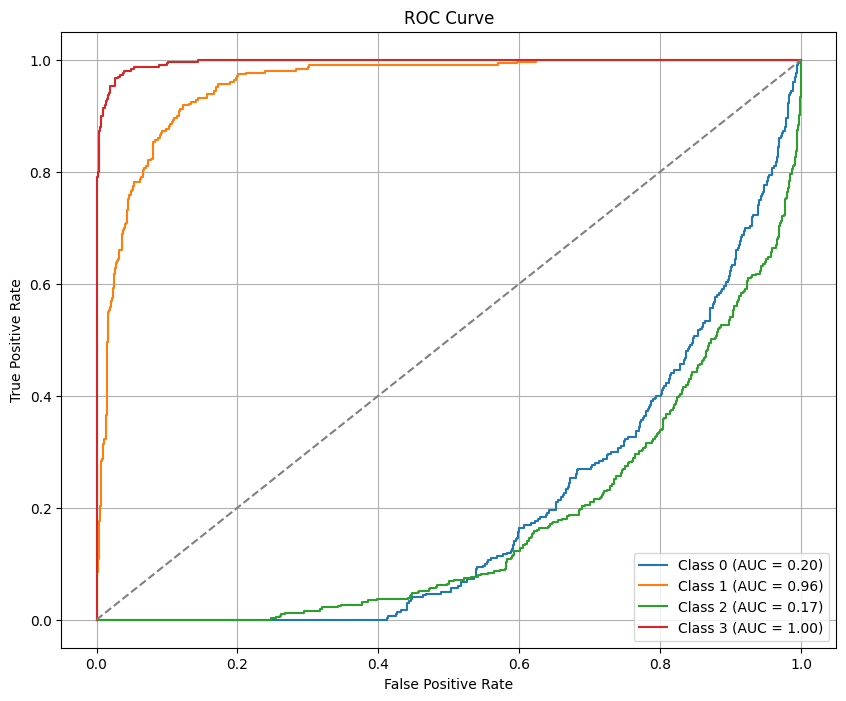

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import os


num_classes = len(os.listdir(train_dir))
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(num_classes))
test_predictions_bin = test_predictions


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt


class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):

    try:

        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]


        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"


        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()
    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


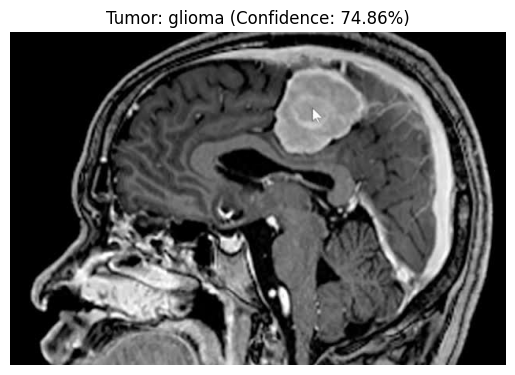

In [ ]:
import os

folder_path = '/content/drive/MyDrive/MRI Images/Testing/meningioma'


image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

if image_files:

    image_path = os.path.join(folder_path, image_files[0])
    detect_and_display(image_path, model)
else:
    print("No image files found in the folder.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


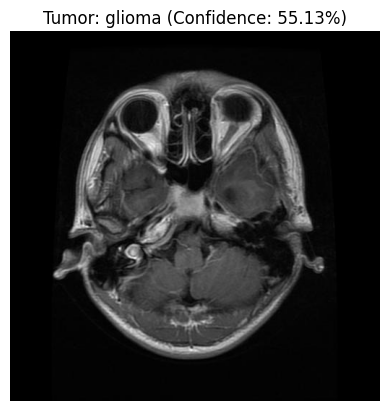

In [ ]:
import os

folder_path = '/content/drive/MyDrive/MRI Images/Testing/glioma'


image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

if image_files:

    image_path = os.path.join(folder_path, image_files[0])
    detect_and_display(image_path, model)
else:
    print("No image files found in the folder.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


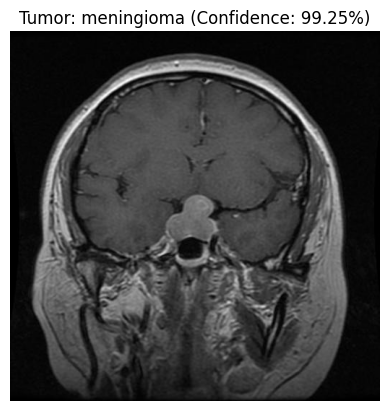

In [ ]:
import os

folder_path = '/content/drive/MyDrive/MRI Images/Testing/pituitary'


image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

if image_files:

    image_path = os.path.join(folder_path, image_files[0])
    detect_and_display(image_path, model)
else:
    print("No image files found in the folder.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


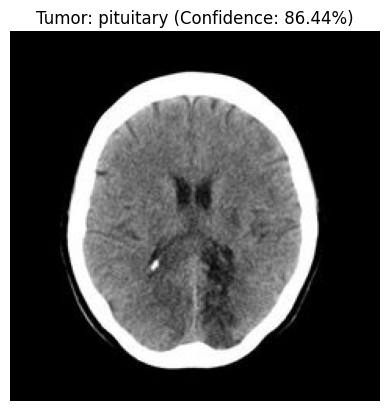

In [ ]:
import os

folder_path = '/content/drive/MyDrive/MRI Images/Testing/notumor'


image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

if image_files:

    image_path = os.path.join(folder_path, image_files[0])
    detect_and_display(image_path, model)
else:
    print("No image files found in the folder.")


In [ ]:
model.save('/content/drive/MyDrive/model_name.h5')
